# Rocks Classification - 02 Data Augmentation

In [1]:
import os
import shutil
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import albumentations as A
import cv2

## Data Distribution Analysis

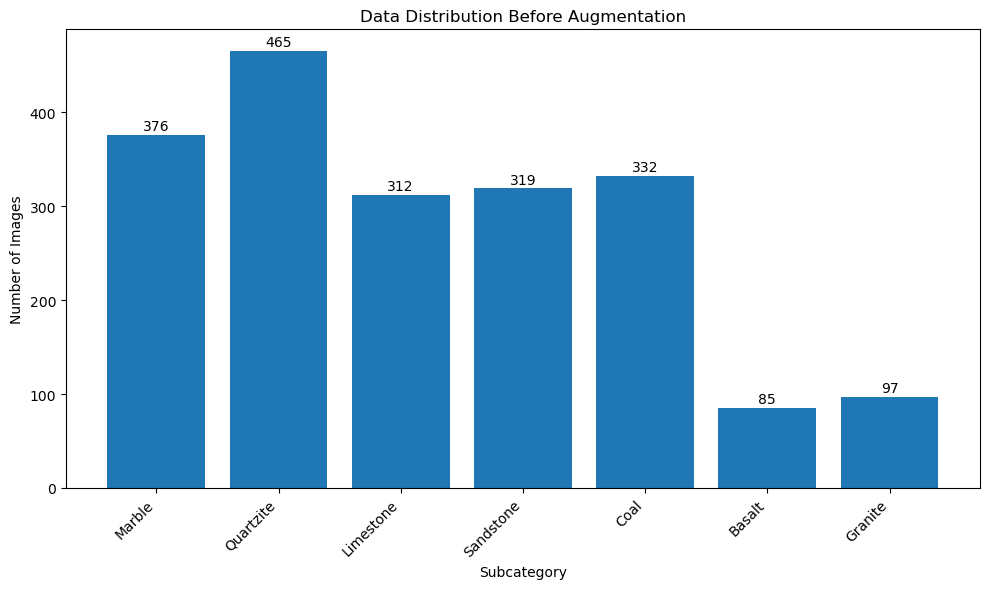

In [4]:
# Directories
cleaned_dir = "./Dataset_Cleaned/"
augmented_dir = "./Dataset_Augmented/"

# Clear and create augmented directory
shutil.rmtree(augmented_dir, ignore_errors=True)
os.makedirs(augmented_dir)

# Count images in cleaned subdirectories (Category/Subcategory)
cleaned_counts = {}
for category in os.listdir(cleaned_dir):
    category_path = os.path.join(cleaned_dir, category)
    if not os.path.isdir(category_path):
        continue
    for subfolder in os.listdir(category_path):
        subfolder_path = os.path.join(category_path, subfolder)
        if os.path.isdir(subfolder_path):
            files = [f for f in os.listdir(subfolder_path) if os.path.isfile(os.path.join(subfolder_path, f))]
            cleaned_counts[subfolder] = len(files)

# Plot subcategory distribution before augmentation
plt.figure(figsize=(10, 6))
plt.bar(cleaned_counts.keys(), cleaned_counts.values())
plt.xlabel('Subcategory')
plt.ylabel('Number of Images')
plt.title('Data Distribution Before Augmentation')
plt.xticks(rotation=45, ha='right')
for i, v in enumerate(cleaned_counts.values()):
    plt.text(i, v + 5, str(v), ha='center')
plt.tight_layout()
plt.show()

The dataset shows an imbalance, with Quartzite having the highest number of images (465) and Basalt the lowest (85). This uneven distribution suggests that data augmentation in the next section will be necessary to balance the dataset and improve model performance by increasing the representation of underrepresented categories like Basalt and Granite.

## Data Augmentation

The code here aims to address dataset imbalance by ensuring all subcategories have an equal number of images (matching the largest subcategory) through augmentation, which helps improve model training by providing a more balanced dataset.

 It increases number of image by the following augmentation transformations using the **albumentations library**
- Resizing
- Rotation
- Flipping
- Cropping
- Brightness adjustments


Total After Deduplication: 1986
Total After Augmentation: 3255
Images Added: 1269


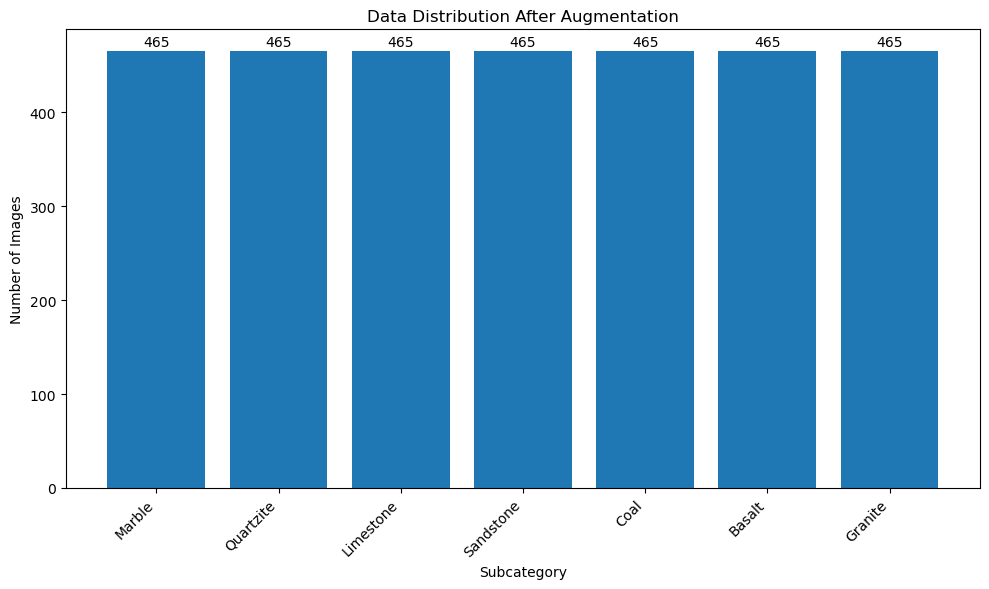

In [5]:
# Augmentation setup
target_count = max(cleaned_counts.values(), default=0)
augment_transform = A.Compose([
    A.Resize(224, 224),
    A.Rotate(limit=90, p=0.5),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.RandomCrop(224, 224, p=0.3),
    A.RandomBrightnessContrast(p=0.3),
    A.GaussNoise(p=0.2),
])

# Augment and copy images
final_counts = {}
for subfolder, count in cleaned_counts.items():
    for category in os.listdir(cleaned_dir):
        cleaned_path = os.path.join(cleaned_dir, category, subfolder)
        if os.path.exists(cleaned_path):
            break
    augmented_path = os.path.join(augmented_dir, subfolder)
    os.makedirs(augmented_path, exist_ok=True)
    
    # Copy all cleaned images
    for file in os.listdir(cleaned_path):
        if os.path.isfile(os.path.join(cleaned_path, file)):
            shutil.copy2(os.path.join(cleaned_path, file), os.path.join(augmented_path, file))
    
    if count >= target_count:
        final_counts[subfolder] = count
        continue
    
    # Augment to reach target_count
    images_to_generate = target_count - count
    valid_files = [f for f in os.listdir(cleaned_path) if f.lower().endswith(('.jpg', '.jpeg', '.png', '.webp', '.jfif'))]
    generated = 0
    
    for _ in range(images_to_generate):
        if not valid_files:
            break
        file = np.random.choice(valid_files)
        try:
            img = np.array(Image.open(os.path.join(cleaned_path, file)).convert('RGB'))
            aug_img = augment_transform(image=img)['image']
            aug_img_bgr = cv2.cvtColor(aug_img, cv2.COLOR_RGB2BGR)
            aug_file = f"aug_{generated}_{os.path.splitext(file)[0]}.jpg"
            if cv2.imwrite(os.path.join(augmented_path, aug_file), aug_img_bgr):
                generated += 1
        except Exception as e:
            print(f"Error augmenting {file} in {subfolder}: {e}")
    
    final_counts[subfolder] = count + generated

# Print summary
# print("\nDataset Counts:")
# print(f"{'Subcategory':<15} {'After Dedup':<12} {'After Augment':<15}")
# print("-" * 45)
# for subfolder in cleaned_counts:
#     print(f"{subfolder:<15} {cleaned_counts[subfolder]:<12} {final_counts[subfolder]:<15}")

total_cleaned = sum(cleaned_counts.values())
total_augmented = sum(final_counts.values())
print(f"\nTotal After Deduplication: {total_cleaned}")
print(f"Total After Augmentation: {total_augmented}")
print(f"Images Added: {total_augmented - total_cleaned}")


# Plot subcategory distribution after augmentation
plt.figure(figsize=(10, 6))
plt.bar(final_counts.keys(), final_counts.values())
plt.xlabel('Subcategory')
plt.ylabel('Number of Images')
plt.title('Data Distribution After Augmentation')
plt.xticks(rotation=45, ha='right')
for i, v in enumerate(final_counts.values()):
    plt.text(i, v + 5, str(v), ha='center')
plt.tight_layout()
plt.show()

This indicates that the augmentation process successfully increased the dataset size, ensuring a more balanced distribution across subcategories for better model performance.